# **Project: Anomaly Detection for AITEX Dataset**
#### Track: PatchCore
## `Notebook 3`: Data Preparation and Exploration for PatchCore
**Author**: Oliver Grau 

**Date**: 27.03.2025  
**Version**: 1.0

## 📚 Table of Contents

- [1. Dataset Overview](#1-dataset-overview)
- [2. Working with Fabric Patch Data](#2-working-with-fabric-patch-data)
- [3. Preprocessing and Normalization](#3-preprocessing-and-normalization)
- [4. Visual Exploration](#4-visual-exploration)
- [5. Notes for PatchCore Usage](#5-notes-for-patchcore-usage)
- [6. Dataset Handling and Preprocessing Steps](#6-dataset-handling-and-preprocessing-steps)
- [7. Exploratory Visualization](#7-exploratory-visualization)
- [8. Conclusion and Whats's Next](#8-conclusion-and-whats-s-next)

---

## 1. Dataset Overview

In this project, you work with fabric images from the AITEX dataset. Each sample is a **256×256 patch** extracted from larger fabric strips.

The dataset is split into two parts:
- **Training set**: only contains *normal* (defect-free) patches.
- **Test set**: contains both normal and *defective* patches, with optional binary masks for localization.

This setup aligns with the **unsupervised** nature of PatchCore, where only *normal* data is used for feature reference (memory bank).

---

## 2. Working with Fabric Patch Data

The dataset is already pre-patched (done in Part 1 - VAEs), so no additional cropping or patch extraction is required in the data pipeline. You can directly load the prepared `256x256` grayscale images.

You will use a custom PyTorch `Dataset` class (`FabricPatchDataset`) that supports:
- Filtering by fabric type (via filename)
- Mode selection: `train` or `test`
- Optional augmentation for training
- Optional resizing and normalization
- Automatic pairing of test masks and defect labels

```python
from dataset import FabricPatchDataset

train_data = FabricPatchDataset(
    image_dir="/path/to/Nodefect",
    mode="train",
    normalize="z-norm",
    augment=False,
    image_size=256
)

test_data = FabricPatchDataset(
    image_dir="/path/to/Defect",
    mask_dir="/path/to/Masks",
    mode="test",
    normalize="z-norm",
    image_size=256
)
```

---

## 3. Preprocessing and Normalization

PatchCore uses pretrained CNNs like ResNet18, which expect **3-channel RGB input**. Since the AITEX dataset contains grayscale images, we simply repeat the single channel to match the expected input shape:

```python
transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # [1,H,W] -> [3,H,W]
```

Normalization options include:
- `zero-one`: values between `[0,1]`
- `z-norm`: centered at `0` with `std=1` → suitable for pretrained networks

Histogram equalization (optional) is also applied to enhance fabric contrast:
```python
transforms.Lambda(lambda img: ImageOps.equalize(img))
```

---

## 4. Visual Exploration

To gain intuition about the dataset, we visualize:
- Random training patches
- Test patches with and without defects
- Associated binary masks (highlighting defect regions)

This helps validate preprocessing and gives a sense of the anomaly types.

Example:
```python
from matplotlib import pyplot as plt

sample_img, sample_mask, label = test_data[42]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Test Image"); plt.imshow(sample_img[0], cmap='gray')
plt.subplot(1,3,2); plt.title("Defect Mask"); plt.imshow(sample_mask[0], cmap='gray')
plt.subplot(1,3,3); plt.title(f"Label: {'Defect' if label else 'Normal'}")
plt.axis('off')
plt.show()
```

---

## 5. Notes for PatchCore Usage

- Training only uses *normal* images → these build the **memory bank**.
- Test mode returns: `(image, mask, binary label)` for evaluation.
- I recommend also returning the filename or patch index for traceability.
- Grayscale inputs are repeated to 3 channels to match ImageNet-pretrained models.
- PatchCore does **not** use reconstruction or masks during training.

This setup enables seamless integration with the PatchCore pipeline, which we'll implement next.

The next part is the preparation of the defect images and their masks. Here we also crop and create patches for each defect image and their mask counterpart.

---

## 6. Dataset Handling and Preprocessing Steps
After cropping and tiling, each image patch undergoes the following preprocessing:
- Convert to grayscale tensors (if using PyTorch: shape `[1, H, W]`)
- Normalize pixel values to `[0, 1]` or `[-1, 1]`
- Optionally apply small augmentations (e.g., random flips, rotations) to improve generalization (experiment with it!)
- Organize into:
  - Training set: Only normal tiles
  - Testing set: Defective tiles + some normal tiles for reference

To streamline training, we will define a PyTorch-style `Dataset` class that:
- Loads preprocessed image tiles
- Returns tensors ready for model input
- Filters images by fabric code


In [5]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.data.dataset import FabricPatchDataset
from torch.utils.data import DataLoader

batch_size = 128

# Test the train dataset
train_dataset = FabricPatchDataset(
    image_dir="./artifacts/preprocessed_patches/256x256/NODefect", #/2311517-195063u",
    mode="train",
    normalize="zero-one",
    augment=False,
    image_size=256,
    use_histogram_equalization=False,
    repeat_3_channels=True,
    #fabric_code="00004" # 210 images with that code
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test the test dataset
test_dataset = FabricPatchDataset(
    image_dir="./artifacts/preprocessed_patches/256x256/Defect",
    mask_dir="./artifacts/preprocessed_patches/256x256/Mask",
    mode="test",
    normalize="zero-one",
    image_size=256,
    use_histogram_equalization=False,
    repeat_3_channels=True,
    augment=False
    #fabric_code="00004" # there are 73 defect images with that code
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for i, (x, y_mask, y_label, filename, idx) in enumerate(test_loader):
    print("Image batch shape:", x.shape)
    print("Mask batch shape:", y_mask.shape)
    print("Patch-level labels:", y_label)
    print("Filename:", filename)
    print("Index:", idx)
    break  # just one batch for demonstration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: True
Using normalization: zero-one
Using augmentations: False
Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: True
Using normalization: zero-one
Using augmentations: False
Image batch shape: torch.Size([128, 3, 256, 256])
Mask batch shape: torch.Size([128, 1, 256, 256])
Patch-level labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Filename: ('defe

<details>
<summary><strong>Advanced: z-norm or zero-one norm?</strong></summary>

There’s a meaningful distinction between **0–1 normalization** and **z-normalization (zero-mean, unit-variance)** when it comes to image data in deep learning, particularly for anomaly detection.

---

### 🔍 Quick Definitions

| Normalization | Formula | Resulting Range | Typical Use |
|---------------|---------|-----------------|-------------|
| **0–1 scaling** | `x / 255` | `[0, 1]` | Common for raw images |
| **z-norm**     | `(x - μ) / σ` | Mean 0, Std 1 | Common for pretrained models or standardization needs |

---

### Does z-norm make sense for image intensity?

#### ✅ Yes — **if done correctly**, and under the right conditions.

But it's **not always necessary or better** than 0–1 scaling.

Let’s compare:

---

### Comparison: 0–1 Normalization vs. z-Norm

#### 🔹 0–1 Normalization (`ToTensor()`)

- **Simple, intuitive**
- Keeps pixel values in a **bounded range** `[0, 1]`
- Most useful when:
  - You're training from scratch
  - The model doesn't rely on specific input distribution
  - You're using MSE-based loss (e.g., autoencoder reconstruction)

✅ **Best for anomaly detection autoencoders** trained on raw grayscale images.

---

#### z-Normalization (`(x - μ) / σ`)

- Normalizes brightness/contrast differences
- Can **center the data** better for some optimizers (especially when images vary in contrast)
- Often used with pretrained models (e.g., ResNet, VGG) which expect `mean/std` normalized RGB

But:  
- For grayscale anomaly detection, z-norm may **not offer real benefits**
- Worse, it could **distort low-level texture details** critical for detecting anomalies

---

### Recommendation for the AITEX Fabric Dataset

| Use Case                        | Recommended Normalization |
|--------------------------------|---------------------------|
| Grayscale Autoencoder from scratch | ✅ 0–1 normalization |
| Color pretrained network         | 🔄 z-norm (with dataset-specific μ, σ) |
| Consistent lighting, industrial setting | ✅ 0–1 is clean and reliable |
| Highly variable contrast/lighting | 🟡 z-norm could help (but test carefully) |

</details>

---

## 7 Exploratory Visualization
To better understand the data, you will visualize several steps:
- A full original image and its cropped version
- A visual example showing how the image is tiled
- One or more individual patches for inspection

These visualizations help validate that our preprocessing pipeline is correctly isolating the fabric texture and preparing clean model inputs.

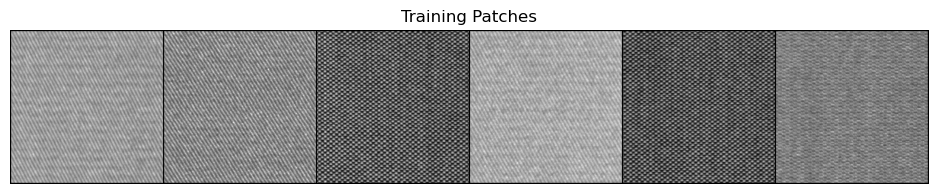

In [6]:
from codebase.data.visualization import show_train_batch

# For train mode
for images in train_loader:
    show_train_batch(images, n=6)
    break

And here are some images with their masks. The number in the image patch corresponds to the label (0 intact, 1 defect) in the mask patch.

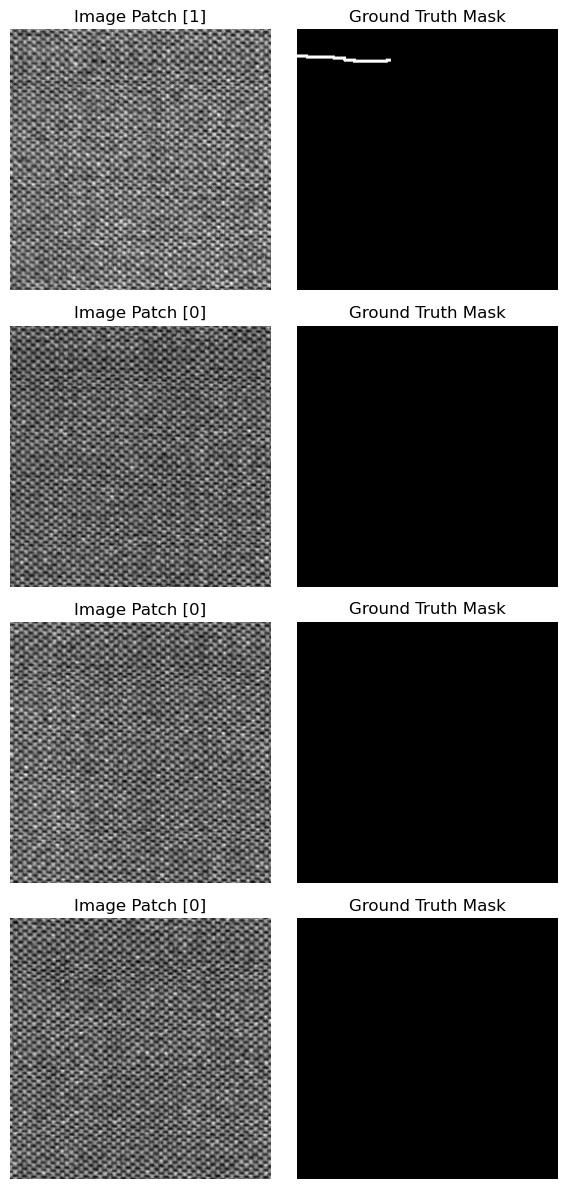

In [7]:
from codebase.data.visualization import show_test_batch

# For test mode
for images, masks, labels, _, _ in test_loader:
    show_test_batch(images, masks, labels, n=4, grayscale=False) 
    break

Let's now filter for **defect patches** only and visualize a few of them.

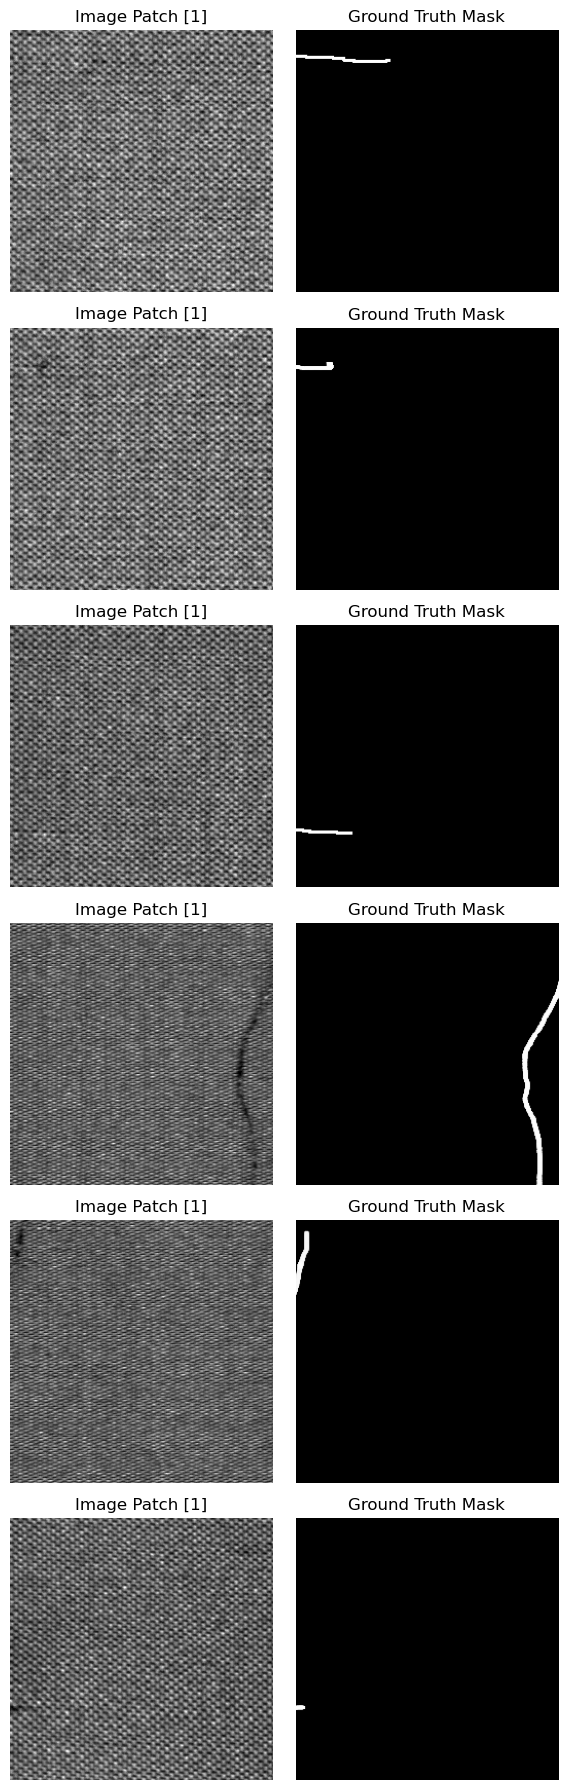

In [8]:
from codebase.data.visualization import show_test_batch
import torch

# Collect all defective samples
defect_images = []
defect_masks = []
defect_labels = []

for images, masks, labels, _, _ in test_loader:
    for img, mask, label in zip(images, masks, labels):
        if label == 1:
            defect_images.append(img)
            defect_masks.append(mask)
            defect_labels.append(label)

    # Stop after collecting enough defect samples
    if len(defect_images) >= 8:
        break

# Stack and show the first 6 defect patches
if len(defect_images) > 0:
    imgs_tensor = torch.stack(defect_images[:6])
    masks_tensor = torch.stack(defect_masks[:6])
    labels_tensor = torch.tensor(defect_labels[:6])
    show_test_batch(imgs_tensor, masks_tensor, labels_tensor, n=6, grayscale=False)
else:
    print("No defect patches found in test set.")


---

# 🔚 Conclusion and What’s Next

In this notebook, we explored and prepared the AITEX dataset for PatchCore-style anomaly detection. We:

- Reviewed the dataset structure and PatchCore assumptions
- Reused our a PyTorch-compatible `Dataset` class from the VAE path
- Applied normalization and preprocessing suitable for pretrained CNNs
- Visualized normal and defective fabric patches with corresponding masks

This groundwork ensures that our data is fully ready for deep feature extraction.

👉 **In the next notebook `04_Feature Extraction with a Pretrained CNN Backbone.ipynb` you:**
- Use a pretrained CNN (like ResNet18,34) to extract high-level features from the image patches
- Store these features to form the memory bank that powers PatchCore
- Visualize and inspect feature activations to gain intuition about what the model "sees"

> Let’s move from raw pixels to powerful feature representations. This is the core of PatchCore’s anomaly detection capability.

<p style="font-size: 0.8em; text-align: center;">© 2025 Oliver Grau. Educational content for personal use only. See LICENSE.txt for full terms and conditions.</p>